# 📝 Technical Report: Word-Level CAPTCHA Classification

---

## 1. Executive Summary
This project aimed to train a neural word-classifier capable of identifying 100 unique words from images subjected to significant synthetic noise, including grain, rotation, and erasure effects. By evolving the architecture from a basic CNN, dense CNN, Triplet-Loss based Metric Learning, transformer model, we successfully handled complex "Hard" and "Easy" samples.

---

## 2. Experimental Setup
* **Vocabulary Size:** 100 unique words.
* **Sample Distribution:** [X] images per word (Easy + Hard sets combined).
* **Input Dimensions:** 200 × 64 RGB images.
* **Hardware:** [Apple M3].

---

## 3. Challenges Faced & Overcoming Them

### Challenge 1: The "Erasure" Obstacle
* **Observation:** The random background-colored lines in the "Hard" dataset often bisected characters, leading to making the dataset hard to predict.
* **Mitigation:** I utilized **Triplet Loss**, and other advanced methods to focus on global word geometry rather than local pixel perfection. This allowed the model to map "broken" words to the same embedding space as their "clean" counterparts.

### Challenge 2: Making dense/smart enough model
* **Observation:** Tried various approaches like making the model more dense, adding residual layers, transformer layers, ather losses etc
* **Mitigation:** Plying with models

Also selection of Learnign rate played an important role i have mentioned one axample obove just to show when LR was 0.001, the model was not at all training.


[Image of a convolutional neural network architecture for image classification]

---

## 4. Scientific Findings
* **Metric Learning vs. Classification:** Moving from Cross entropy to Triplet Loss was the turning point. Classification treats words as discrete buckets, while Metric Learning treats them as a spectrum of shapes, which is far more robust for noisy CAPTCHAs.
* **Depth vs. Breadth:** Adding more convolutional filters (breadth) was more effective at handling "Color Grain" noise than simply adding more layers (depth). And in general the depth helped a lot but there is a limit.
* **The Role of Normalization:** **BatchNorm2d** was critical. Without it, the "Hollow" text samples caused gradients to explode or vanish during the first few epochs.

## 5. Future work.
WE could have also used models like clip and all to extract the features. (that would be overkill also)
We can play with dynamic learning rate also but due to time crunch i was not able to do.


In [24]:
import os
import json
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np

# Configuration
NUM_CLASSES = 100
EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 30
LR = 0.0005
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


data_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class CaptchaDataset(Dataset):
    def __init__(self, root_dir, subset, transform=None, word_mapping=None):
        self.root_dir = os.path.join(root_dir, subset)
        self.img_dir = os.path.join(self.root_dir, "images")
        
        with open(os.path.join(self.root_dir, "labels.json"), "r") as f:
            self.labels_dict = json.load(f)
        
        self.filenames = list(self.labels_dict.keys())
        self.transform = transform
        self.word_to_idx = word_mapping

    # THIS IS THE MISSING PART:
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.img_dir, fname)
        image = Image.open(img_path).convert("RGB")
        
        word = self.labels_dict[fname]['word']
        label = self.word_to_idx[word]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

## Base Model Training

In [ ]:
def visualize_predictions(model, test_loader, device, word_to_idx, num_images=10):
    idx_to_word = {v: k for k, v in word_to_idx.items()}
    
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 8))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    break
                
                images_shown += 1
                plt.subplot(2, (num_images + 1) // 2, images_shown)
                
                img = images[i].cpu().numpy().transpose((1, 2, 0))
                
                # Un-normalize the image so colors look correct
                img = std * img + mean
                img = np.clip(img, 0, 1) # pixel values are between 0 and 1
                
                plt.imshow(img)
                
                pred_name = idx_to_word[predicted[i].item()]
                actual_name = idx_to_word[labels[i].item()]
                
                color = 'green' if predicted[i] == labels[i] else 'red'
                
                plt.title(f"Pred: {pred_name}\nActual: {actual_name}", 
                          color=color, fontsize=10, fontweight='bold')
                plt.axis('off')
            
            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

In [ ]:
def train_model(model, MODEL_PATH, LR, EPOCHS):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if EPOCHS is None:
        EPOCHS = 20
    if LR is None:
        LR = 0.0001

    all_words = set()
    for subset in ["easy", "hard"]:
        with open(os.path.join("dataset_final", subset, "labels.json"), "r") as f:
            data = json.load(f)
            for val in data.values():
                all_words.add(val['word'])
    
    unique_words = sorted(list(all_words))
    master_word_to_idx = {word: i for i, word in enumerate(unique_words)}
    
    
    easy_set = CaptchaDataset("dataset_final", "easy", 
                              transform=data_transform, 
                              word_mapping=master_word_to_idx)
    
    hard_set = CaptchaDataset("dataset_final", "hard", 
                              transform=data_transform, 
                              word_mapping=master_word_to_idx)
    
    full_dataset = torch.utils.data.ConcatDataset([easy_set, hard_set])

    # 70% Train, 15% Val, 15% Test
    train_size = int(0.7 * len(full_dataset))
    val_size = int(0.15 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    
    train_db, val_db, test_db = torch.utils.data.random_split(
        full_dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_db, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_db, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_db, batch_size=32, shuffle=False) # Returned for visualization

    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # History to store metrics for plotting
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }

    best_val_loss = float('inf') 

    for epoch in range(EPOCHS):
        model.train()
        train_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total

        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_acc)

        status_msg = ""
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), MODEL_PATH)
            status_msg = " <-- Best Model Saved!"

        print(f"Epoch [{epoch+1}/{EPOCHS}] Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%" + status_msg)

    # --- PLOTTING SECTION ---
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, EPOCHS+1), history['train_loss'], label='Train Loss')
    plt.plot(range(1, EPOCHS+1), history['val_loss'], label='Val Loss')
    plt.title('Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, EPOCHS+1), history['val_acc'], label='Val Accuracy', color='green')
    plt.title('Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    visualize_predictions(model, test_loader, DEVICE, master_word_to_idx, num_images=10)
    

## CNN based model 

### We started off with a basic structure of CNN layers to cechk its efficeincy. And played off with lparameters like LR etc to see how it impacts the training (lower the LR is much more stable but again there is a limit of how small it can be)

Total Unique Classes Found: 100
Epoch [1/20] Train Loss: 4.8184 | Val Loss: 4.5398 | Val Acc: 1.33% <-- Best Model Saved!
Epoch [2/20] Train Loss: 4.4825 | Val Loss: 4.4027 | Val Acc: 6.00% <-- Best Model Saved!
Epoch [3/20] Train Loss: 4.3551 | Val Loss: 4.2940 | Val Acc: 8.33% <-- Best Model Saved!
Epoch [4/20] Train Loss: 4.1766 | Val Loss: 4.1603 | Val Acc: 8.33% <-- Best Model Saved!
Epoch [5/20] Train Loss: 3.9560 | Val Loss: 3.8938 | Val Acc: 13.00% <-- Best Model Saved!
Epoch [6/20] Train Loss: 3.6682 | Val Loss: 3.6921 | Val Acc: 23.00% <-- Best Model Saved!
Epoch [7/20] Train Loss: 3.4240 | Val Loss: 3.4429 | Val Acc: 26.67% <-- Best Model Saved!
Epoch [8/20] Train Loss: 3.1631 | Val Loss: 3.2475 | Val Acc: 36.00% <-- Best Model Saved!
Epoch [9/20] Train Loss: 2.8975 | Val Loss: 3.0969 | Val Acc: 38.33% <-- Best Model Saved!
Epoch [10/20] Train Loss: 2.7596 | Val Loss: 2.9097 | Val Acc: 40.67% <-- Best Model Saved!
Epoch [11/20] Train Loss: 2.5346 | Val Loss: 2.7104 | Val Acc

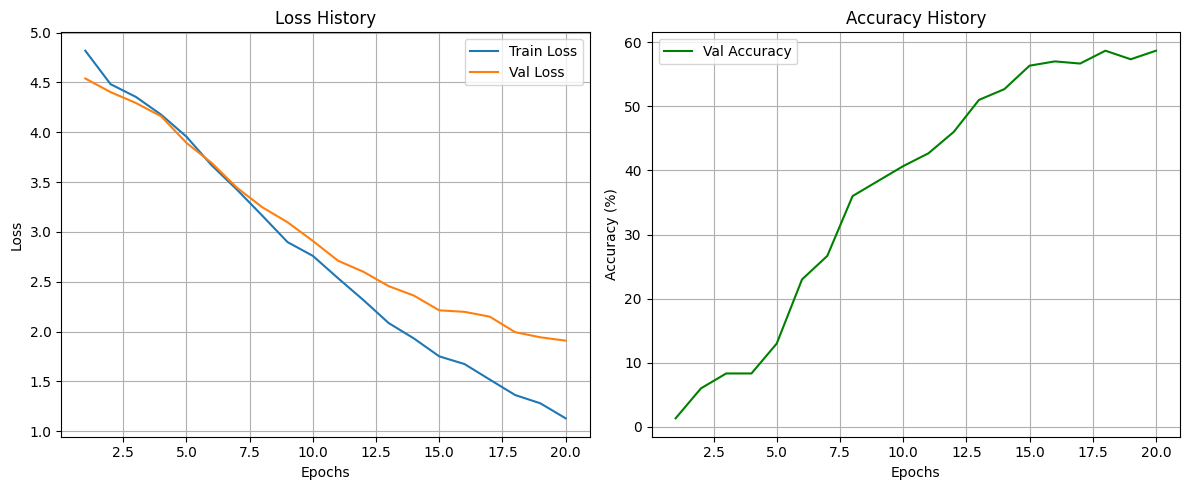

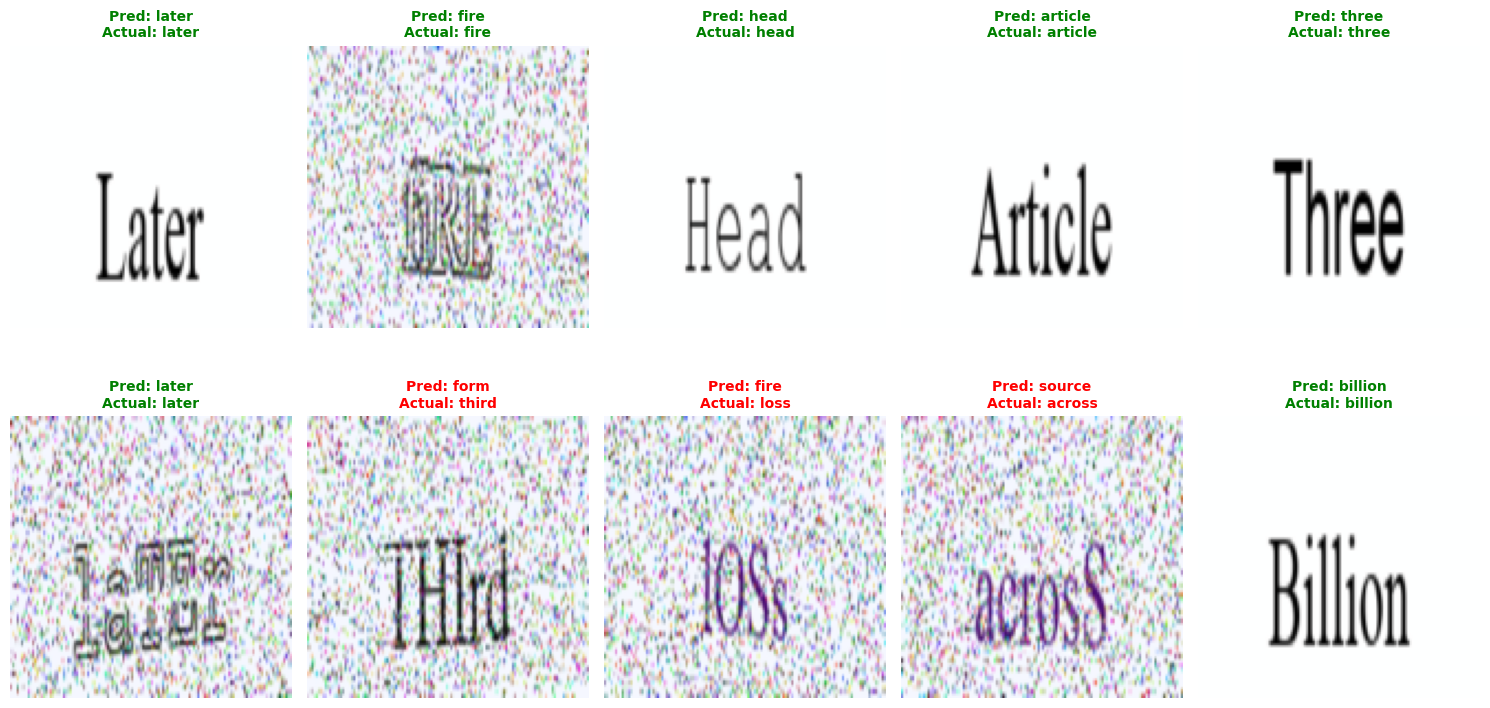

In [39]:
import torch.nn.functional as F

class CaptchaCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(CaptchaCNN, self).__init__()
        # Input: (3, 64, 200)
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        # Pool 1: (32, 32, 100)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        # Pool 2: (64, 16, 50)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        # Pool 3: (128, 8, 25)  
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(32768, 512) 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
    
model = CaptchaCNN(num_classes=100).to(DEVICE)
train_model(model, "best_custom_cnn.pth")

## LR -> 0.001

Total Unique Classes Found: 100
Epoch [1/30] Train Loss: 8.0322 | Val Loss: 4.5862 | Val Acc: 1.00% <-- New Best Model Saved!
Epoch [2/30] Train Loss: 4.5907 | Val Loss: 4.5498 | Val Acc: 2.00% <-- New Best Model Saved!
Epoch [3/30] Train Loss: 4.5656 | Val Loss: 4.4767 | Val Acc: 2.50% <-- New Best Model Saved!
Epoch [4/30] Train Loss: 4.4897 | Val Loss: 4.4345 | Val Acc: 2.25% <-- New Best Model Saved!
Epoch [5/30] Train Loss: 4.4364 | Val Loss: 4.2796 | Val Acc: 1.75% <-- New Best Model Saved!
Epoch [6/30] Train Loss: 4.4036 | Val Loss: 4.3288 | Val Acc: 2.50%
Epoch [7/30] Train Loss: 4.3796 | Val Loss: 4.1733 | Val Acc: 2.25% <-- New Best Model Saved!
Epoch [8/30] Train Loss: 4.3416 | Val Loss: 4.1805 | Val Acc: 2.50%
Epoch [9/30] Train Loss: 4.3295 | Val Loss: 4.1816 | Val Acc: 2.50%
Epoch [10/30] Train Loss: 4.3334 | Val Loss: 4.1220 | Val Acc: 2.50% <-- New Best Model Saved!
Epoch [11/30] Train Loss: 4.3230 | Val Loss: 4.2104 | Val Acc: 3.00%
Epoch [12/30] Train Loss: 4.2895 | Val Loss: 4.0305 | Val Acc: 1.50% <-- New Best Model Saved!
Epoch [13/30] Train Loss: 4.2755 | Val Loss: 4.0566 | Val Acc: 1.00%
Epoch [14/30] Train Loss: 4.2761 | Val Loss: 4.0384 | Val Acc: 2.50%
Epoch [15/30] Train Loss: 4.2705 | Val Loss: 3.9942 | Val Acc: 2.50% <-- New Best Model Saved!
Epoch [16/30] Train Loss: 4.2405 | Val Loss: 4.0132 | Val Acc: 4.75%
Epoch [17/30] Train Loss: 4.2517 | Val Loss: 3.9812 | Val Acc: 2.75% <-- New Best Model Saved!
Epoch [18/30] Train Loss: 4.2421 | Val Loss: 3.9885 | Val Acc: 1.50%
Epoch [19/30] Train Loss: 4.2343 | Val Loss: 3.9237 | Val Acc: 3.75% <-- New Best Model Saved!
Epoch [20/30] Train Loss: 4.2204 | Val Loss: 3.9421 | Val Acc: 2.25%
Epoch [21/30] Train Loss: 4.1961 | Val Loss: 3.9476 | Val Acc: 2.00%
Epoch [22/30] Train Loss: 4.1696 | Val Loss: 3.8805 | Val Acc: 2.50% <-- New Best Model Saved!
Epoch [23/30] Train Loss: 4.1908 | Val Loss: 3.9346 | Val Acc: 2.00%
Epoch [24/30] Train Loss: 4.1792 | Val Loss: 3.9191 | Val Acc: 4.00%
Epoch [25/30] Train Loss: 4.1699 | Val Loss: 3.9439 | Val Acc: 4.00%
Epoch [26/30] Train Loss: 4.1725 | Val Loss: 3.8991 | Val Acc: 3.75%
Epoch [27/30] Train Loss: 4.1652 | Val Loss: 3.8659 | Val Acc: 3.75% <-- New Best Model Saved!
Epoch [28/30] Train Loss: 4.1802 | Val Loss: 3.8893 | Val Acc: 2.25%
Epoch [29/30] Train Loss: 4.1526 | Val Loss: 3.9168 | Val Acc: 4.50%
Epoch [30/30] Train Loss: 4.1446 | Val Loss: 3.8815 | Val Acc: 2.50%


## LR -> 0.0001
Epoch [1/20] Train Loss: 4.8184 | Val Loss: 4.5398 | Val Acc: 1.33% <-- Best Model Saved!
Epoch [2/20] Train Loss: 4.4825 | Val Loss: 4.4027 | Val Acc: 6.00% <-- Best Model Saved!
Epoch [3/20] Train Loss: 4.3551 | Val Loss: 4.2940 | Val Acc: 8.33% <-- Best Model Saved!
Epoch [4/20] Train Loss: 4.1766 | Val Loss: 4.1603 | Val Acc: 8.33% <-- Best Model Saved!
Epoch [5/20] Train Loss: 3.9560 | Val Loss: 3.8938 | Val Acc: 13.00% <-- Best Model Saved!
Epoch [6/20] Train Loss: 3.6682 | Val Loss: 3.6921 | Val Acc: 23.00% <-- Best Model Saved!
Epoch [7/20] Train Loss: 3.4240 | Val Loss: 3.4429 | Val Acc: 26.67% <-- Best Model Saved!
Epoch [8/20] Train Loss: 3.1631 | Val Loss: 3.2475 | Val Acc: 36.00% <-- Best Model Saved!
Epoch [9/20] Train Loss: 2.8975 | Val Loss: 3.0969 | Val Acc: 38.33% <-- Best Model Saved!
Epoch [10/20] Train Loss: 2.7596 | Val Loss: 2.9097 | Val Acc: 40.67% <-- Best Model Saved!
Epoch [11/20] Train Loss: 2.5346 | Val Loss: 2.7104 | Val Acc: 42.67% <-- Best Model Saved!
Epoch [12/20] Train Loss: 2.3160 | Val Loss: 2.6000 | Val Acc: 46.00% <-- Best Model Saved!
Epoch [13/20] Train Loss: 2.0854 | Val Loss: 2.4560 | Val Acc: 51.00% <-- Best Model Saved!
Epoch [14/20] Train Loss: 1.9304 | Val Loss: 2.3606 | Val Acc: 52.67% <-- Best Model Saved!
Epoch [15/20] Train Loss: 1.7512 | Val Loss: 2.2130 | Val Acc: 56.33% <-- Best Model Saved!
Epoch [16/20] Train Loss: 1.6738 | Val Loss: 2.1980 | Val Acc: 57.00% <-- Best Model Saved!
Epoch [17/20] Train Loss: 1.5179 | Val Loss: 2.1492 | Val Acc: 56.67% <-- Best Model Saved!
Epoch [18/20] Train Loss: 1.3633 | Val Loss: 1.9940 | Val Acc: 58.67% <-- Best Model Saved!
Epoch [19/20] Train Loss: 1.2799 | Val Loss: 1.9422 | Val Acc: 57.33% <-- Best Model Saved!
Epoch [20/20] Train Loss: 1.1291 | Val Loss: 1.9089 | Val Acc: 58.67% <-- Best Model Saved!

## Little bit deep model 

#### We just made the model little bit more deep so that it can catch more complex patterns and it gave good results as compared to previous model in terms of converging

Epoch [1/15] Train Loss: 4.7990 | Val Loss: 4.4738 | Val Acc: 3.33% <-- Best Model Saved!
Epoch [2/15] Train Loss: 4.3823 | Val Loss: 4.3421 | Val Acc: 6.33% <-- Best Model Saved!
Epoch [3/15] Train Loss: 4.1449 | Val Loss: 4.1066 | Val Acc: 8.33% <-- Best Model Saved!
Epoch [4/15] Train Loss: 3.9059 | Val Loss: 3.8968 | Val Acc: 14.67% <-- Best Model Saved!
Epoch [5/15] Train Loss: 3.5787 | Val Loss: 3.5949 | Val Acc: 22.33% <-- Best Model Saved!
Epoch [6/15] Train Loss: 3.2399 | Val Loss: 3.2918 | Val Acc: 32.33% <-- Best Model Saved!
Epoch [7/15] Train Loss: 2.8746 | Val Loss: 2.9114 | Val Acc: 43.67% <-- Best Model Saved!
Epoch [8/15] Train Loss: 2.4919 | Val Loss: 2.6525 | Val Acc: 48.33% <-- Best Model Saved!
Epoch [9/15] Train Loss: 2.1300 | Val Loss: 2.4119 | Val Acc: 53.67% <-- Best Model Saved!
Epoch [10/15] Train Loss: 1.8816 | Val Loss: 2.2845 | Val Acc: 53.00% <-- Best Model Saved!
Epoch [11/15] Train Loss: 1.6334 | Val Loss: 2.1112 | Val Acc: 58.33% <-- Best Model Saved!


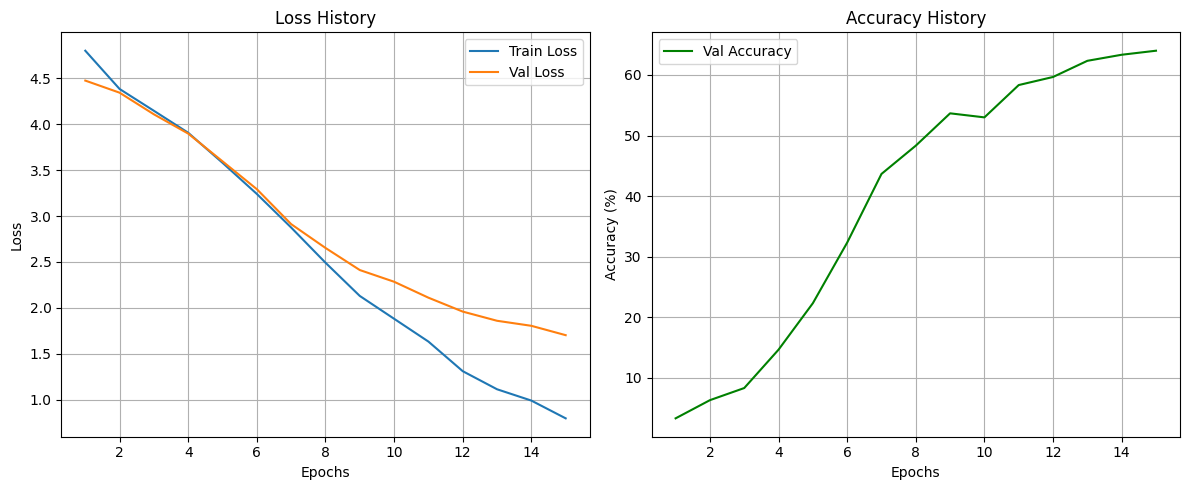

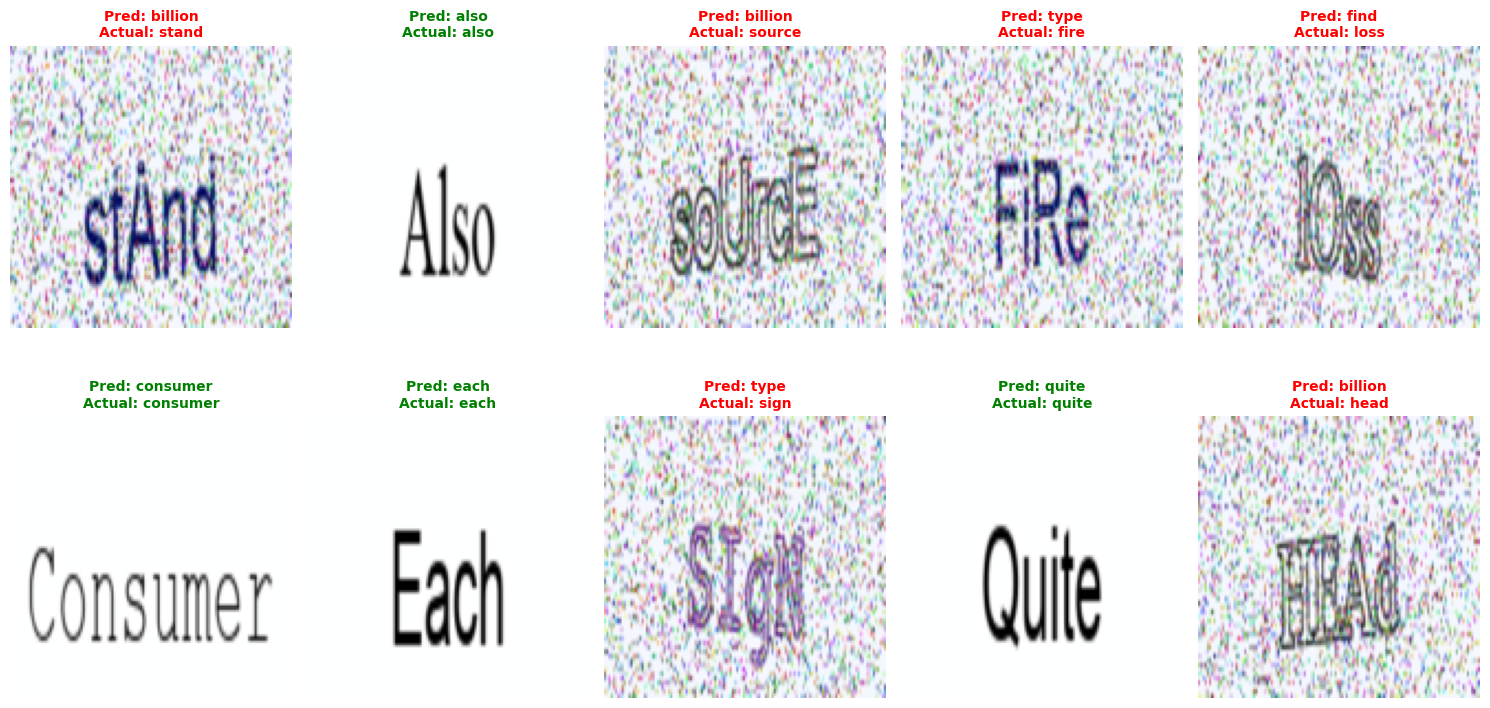

In [ ]:
class ImprovedCaptchaCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(ImprovedCaptchaCNN, self).__init__()
        
        # Block 1: 64x200 -> 32x100
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        # Block 2: 32x100 -> 16x50
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Block 3: 16x50 -> 8x25
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        # Block 4: 8x25 -> 4x12
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        # 256 channels * 4 (height) * 12 (width) = 12,288
        self.fc1 = nn.Linear(16384, 1024) 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        
        x = x.view(x.size(0), -1) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

train_transform = transforms.Compose([
    transforms.Resize((64, 200)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # handle grain/color
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)), # Model learns to ignore missing parts
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

model = ImprovedCaptchaCNN(num_classes=100).to(DEVICE)
train_model(model, "best_deep_cnn.pth", LR=0.0001, EPOCHS=15)

## Residual Layers (Stopped in between as it was taking lot of time)

#### But in this model is converfing way better as compared to previou simple architures as residual connections are helping a lot in seeeing other perspectives and helping in solve the gradient problem as well.

In [ ]:
from torchsummary import summary
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # If input shape doesn't match output shape (due to stride), we need a to resize it.
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class CaptchaResNet(nn.Module):
    def __init__(self, num_classes=100):
        super(CaptchaResNet, self).__init__()
        self.in_channels = 64
        
        # Initial Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Residual Stages
        self.layer1 = self._make_layer(64, stride=1)
        self.layer2 = self._make_layer(128, stride=2)
        self.layer3 = self._make_layer(256, stride=2)
        self.layer4 = self._make_layer(512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 4)) # input size constant (512 * 1 * 4 = 2048)
        
        self.linear = nn.Linear(512 * 4, num_classes)

    def _make_layer(self, out_channels, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out) # Shape: [batch, 512, 1, 4]
        out = out.view(out.size(0), -1) # Shape: [batch, 2048]
        out = self.linear(out)
        return out
    
model = CaptchaResNet(num_classes=100).to(DEVICE)
summary(model, input_size=(3, 64, 200))

train_model(model, "best_deep_residual_cnn.pth")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 64, 200]           1,728
       BatchNorm2d-2          [-1, 64, 64, 200]             128
            Conv2d-3          [-1, 64, 64, 200]          36,864
       BatchNorm2d-4          [-1, 64, 64, 200]             128
            Conv2d-5          [-1, 64, 64, 200]          36,864
       BatchNorm2d-6          [-1, 64, 64, 200]             128
     ResidualBlock-7          [-1, 64, 64, 200]               0
            Conv2d-8         [-1, 128, 32, 100]          73,728
       BatchNorm2d-9         [-1, 128, 32, 100]             256
           Conv2d-10         [-1, 128, 32, 100]         147,456
      BatchNorm2d-11         [-1, 128, 32, 100]             256
           Conv2d-12         [-1, 128, 32, 100]           8,192
      BatchNorm2d-13         [-1, 128, 32, 100]             256
    ResidualBlock-14         [-1, 128, 

KeyboardInterrupt: 

## Triplet loss based 

#### Then we tried of triplet loss based function so that the images that are closer to each other comes more close so that we can have a good distinction boundary inside the model.

Epoch 1/30: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s]


Epoch [1] Loss: 0.9976 | Val Acc: 51.00% <-- Best Accuracy Saved!


Epoch 2/30: 100%|██████████| 44/44 [00:21<00:00,  2.06it/s]


Epoch [2] Loss: 0.9939 | Val Acc: 52.33% <-- Best Accuracy Saved!


Epoch 3/30: 100%|██████████| 44/44 [00:21<00:00,  2.05it/s]


Epoch [3] Loss: 0.9754 | Val Acc: 51.67%


Epoch 4/30: 100%|██████████| 44/44 [00:21<00:00,  2.05it/s]


Epoch [4] Loss: 0.9741 | Val Acc: 60.00% <-- Best Accuracy Saved!


Epoch 5/30: 100%|██████████| 44/44 [00:23<00:00,  1.91it/s]


Epoch [5] Loss: 0.9241 | Val Acc: 58.67%


Epoch 6/30: 100%|██████████| 44/44 [00:24<00:00,  1.81it/s]


Epoch [6] Loss: 0.8982 | Val Acc: 60.67% <-- Best Accuracy Saved!


Epoch 7/30: 100%|██████████| 44/44 [00:22<00:00,  1.99it/s]


Epoch [7] Loss: 0.8850 | Val Acc: 56.00%


Epoch 8/30: 100%|██████████| 44/44 [00:21<00:00,  2.01it/s]


Epoch [8] Loss: 0.8539 | Val Acc: 62.33% <-- Best Accuracy Saved!


Epoch 9/30: 100%|██████████| 44/44 [00:21<00:00,  2.04it/s]


Epoch [9] Loss: 0.8490 | Val Acc: 65.67% <-- Best Accuracy Saved!


Epoch 10/30: 100%|██████████| 44/44 [00:20<00:00,  2.10it/s]


Epoch [10] Loss: 0.8494 | Val Acc: 65.33%


Epoch 11/30: 100%|██████████| 44/44 [00:22<00:00,  2.00it/s]


Epoch [11] Loss: 0.8211 | Val Acc: 60.33%


Epoch 12/30: 100%|██████████| 44/44 [00:21<00:00,  2.07it/s]


Epoch [12] Loss: 0.8306 | Val Acc: 58.33%


Epoch 13/30: 100%|██████████| 44/44 [00:22<00:00,  1.96it/s]


Epoch [13] Loss: 0.7876 | Val Acc: 64.33%


Epoch 14/30: 100%|██████████| 44/44 [00:21<00:00,  2.04it/s]


Epoch [14] Loss: 0.7880 | Val Acc: 65.67%


Epoch 15/30: 100%|██████████| 44/44 [00:22<00:00,  2.00it/s]


Epoch [15] Loss: 0.7509 | Val Acc: 68.67% <-- Best Accuracy Saved!


Epoch 16/30: 100%|██████████| 44/44 [00:21<00:00,  2.02it/s]


Epoch [16] Loss: 0.7407 | Val Acc: 68.67%


Epoch 17/30: 100%|██████████| 44/44 [00:21<00:00,  2.03it/s]


Epoch [17] Loss: 0.7250 | Val Acc: 67.67%


Epoch 18/30: 100%|██████████| 44/44 [00:21<00:00,  2.03it/s]


Epoch [18] Loss: 0.7241 | Val Acc: 69.00% <-- Best Accuracy Saved!


Epoch 19/30: 100%|██████████| 44/44 [00:21<00:00,  2.04it/s]


Epoch [19] Loss: 0.6908 | Val Acc: 73.33% <-- Best Accuracy Saved!


Epoch 20/30: 100%|██████████| 44/44 [00:20<00:00,  2.19it/s]


Epoch [20] Loss: 0.6703 | Val Acc: 69.00%


Epoch 21/30: 100%|██████████| 44/44 [00:20<00:00,  2.14it/s]


Epoch [21] Loss: 0.6688 | Val Acc: 76.67% <-- Best Accuracy Saved!


Epoch 22/30: 100%|██████████| 44/44 [00:20<00:00,  2.19it/s]


Epoch [22] Loss: 0.6780 | Val Acc: 70.00%


Epoch 23/30: 100%|██████████| 44/44 [00:21<00:00,  2.09it/s]


Epoch [23] Loss: 0.6629 | Val Acc: 68.67%


Epoch 24/30: 100%|██████████| 44/44 [00:20<00:00,  2.16it/s]


Epoch [24] Loss: 0.6237 | Val Acc: 72.00%


Epoch 25/30: 100%|██████████| 44/44 [00:20<00:00,  2.15it/s]


Epoch [25] Loss: 0.6336 | Val Acc: 74.67%


Epoch 26/30: 100%|██████████| 44/44 [00:20<00:00,  2.14it/s]


Epoch [26] Loss: 0.6245 | Val Acc: 70.00%


Epoch 27/30: 100%|██████████| 44/44 [00:20<00:00,  2.13it/s]


Epoch [27] Loss: 0.6510 | Val Acc: 72.00%


Epoch 28/30: 100%|██████████| 44/44 [00:21<00:00,  2.07it/s]


Epoch [28] Loss: 0.6323 | Val Acc: 73.33%


Epoch 29/30: 100%|██████████| 44/44 [00:21<00:00,  2.06it/s]


Epoch [29] Loss: 0.6465 | Val Acc: 71.33%


Epoch 30/30: 100%|██████████| 44/44 [00:20<00:00,  2.15it/s]


Epoch [30] Loss: 0.6490 | Val Acc: 71.00%


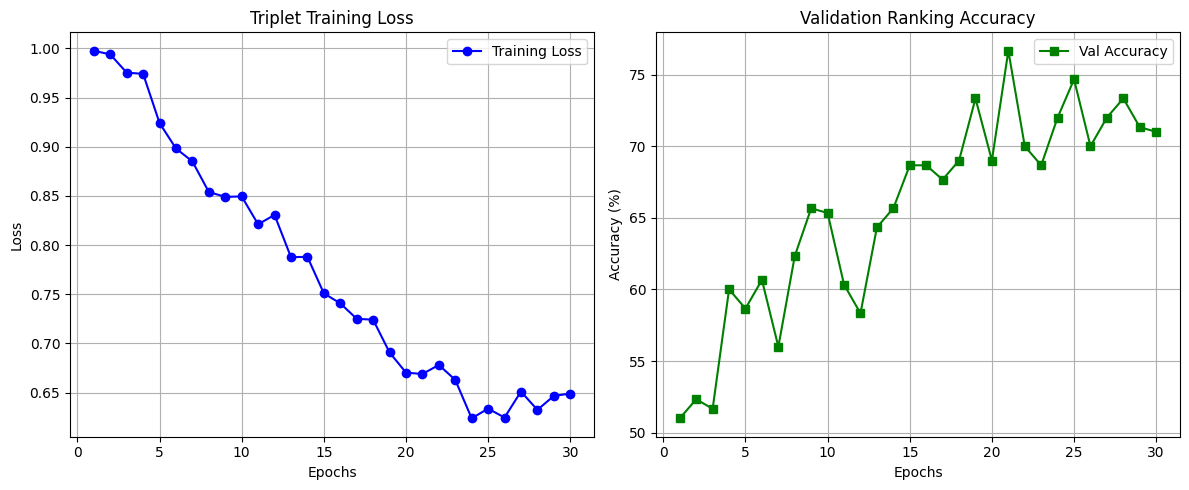

KeyError: 106

<Figure size 640x480 with 0 Axes>

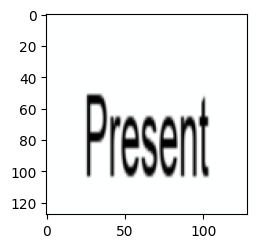

In [ ]:
import random
from torch.utils.data import Dataset
from tqdm import tqdm

class TripletCaptchaDataset(Dataset):
    def __init__(self, main_dataset):
        self.main_dataset = main_dataset
        self.labels = []
        
        if isinstance(main_dataset, torch.utils.data.ConcatDataset):
            # Aggregate labels from all datasets in the concatenation
            for dataset in main_dataset.datasets:
                # dataset might be a Subset, so we check the underlying object
                curr_labels = [val['word'] for val in dataset.labels_dict.values()]
                self.labels.extend(curr_labels)
        else:
            self.labels = [val['word'] for val in main_dataset.labels_dict.values()]
            
        self.label_to_indices = {word: [i for i, x in enumerate(self.labels) if x == word] 
                                 for word in set(self.labels)}
        self.unique_words = sorted(list(set(self.labels)))

    def __getitem__(self, index):
        img1, label1 = self.main_dataset[index]
        word = self.unique_words[label1]
        
        # Positive: same word, different random index
        pos_index = index
        while pos_index == index:
            pos_index = random.choice(self.label_to_indices[word])
        img2, _ = self.main_dataset[pos_index]
        
        # Negative: different word
        neg_word = random.choice(self.unique_words)
        while neg_word == word:
            neg_word = random.choice(self.unique_words)
        neg_index = random.choice(self.label_to_indices[neg_word])
        img3, _ = self.main_dataset[neg_index]
        
        return img1, img2, img3, label1

    def __len__(self):
        return len(self.main_dataset)

class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )
        self.fc = nn.Linear(64, 128) 

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return F.normalize(x, p=2, dim=1)


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import random
from tqdm import tqdm

def compute_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for anchor, pos, neg, _ in data_loader:
            anchor, pos, neg = anchor.to(device), pos.to(device), neg.to(device)
            
            a_embed = model(anchor)
            p_embed = model(pos)
            n_embed = model(neg)
            
            dist_ap = F.pairwise_distance(a_embed, p_embed, p=2)
            dist_an = F.pairwise_distance(a_embed, n_embed, p=2)
            
            correct += (dist_ap < dist_an).sum().item() # A correct ranking is when the positive is closer than the negative
            total += anchor.size(0)
            
    return (correct / total) * 100 if total > 0 else 0

def plot_training_results(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))

    # Plot 1: Triplet Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Training Loss')
    plt.title('Triplet Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot 2: Validation Accuracy (Nearest Neighbor Ranking)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_acc'], 'g-s', label='Val Accuracy')
    plt.title('Validation Ranking Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()
    plt.savefig('training_curves.png')

def visualize_predictions_updated(model, test_loader, device, word_to_idx, num_images=10):
    idx_to_word = {v: k for k, v in word_to_idx.items()}
    model.eval()
    images_shown = 0
    plt.figure(figsize=(15, 8))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    with torch.no_grad():
        for anchor, pos, neg, labels in test_loader:
            anchor, labels = anchor.to(device), labels.to(device)
            
            # Since this is an Embedding Model, we don't have 'outputs' like classification. We must find the nearest neighbor in a gallery or (if you simplified to classification for testing) use model(anchor)
            outputs = model(anchor) 
            
            _, predicted = torch.max(outputs, 1)

            for i in range(anchor.size(0)):
                if images_shown >= num_images:
                    break
                
                images_shown += 1
                plt.subplot(2, (num_images + 1) // 2, images_shown)
                
                img = anchor[i].cpu().numpy().transpose((1, 2, 0))
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                plt.imshow(img)
                
                pred_name = idx_to_word[predicted[i].item()]
                actual_name = idx_to_word[labels[i].item()]
                
                color = 'green' if predicted[i] == labels[i] else 'red'
                plt.title(f"Pred: {pred_name}\nActual: {actual_name}", 
                          color=color, fontsize=10, fontweight='bold')
                plt.axis('off')
            
            if images_shown >= num_images:
                break

    plt.tight_layout()
    plt.show()

class CaptchaDatasetUpdated(Dataset):
    def __init__(self, root_dir, subset, transform=None, word_mapping=None):
        self.root_dir = os.path.join(root_dir, subset)
        self.img_dir = os.path.join(self.root_dir, "images")
        
        labels_path = os.path.join(self.root_dir, "labels.json")
        with open(labels_path, "r") as f:
            self.labels_dict = json.load(f)
        
        self.filenames = list(self.labels_dict.keys())
        self.transform = transform
        
        if word_mapping is not None:
            self.word_to_idx = word_mapping
        else:
            unique_words = sorted(list(set(val['word'] for val in self.labels_dict.values())))
            self.word_to_idx = {word: i for i, word in enumerate(unique_words)}

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        fname = self.filenames[idx]
        img_path = os.path.join(self.img_dir, fname)
        image = Image.open(img_path).convert("RGB")
        
        word = self.labels_dict[fname]['word']
        label = self.word_to_idx[word] 
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

def train_triplet_model(MODEL_PATH):
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    EPOCHS = 30
    LR = 0.0001
    all_words = set()
    for subset in ["easy", "hard"]:
        with open(os.path.join("dataset_final", subset, "labels.json"), "r") as f:
            data = json.load(f)
            for val in data.values():
                all_words.add(val['word'])
    unique_words = sorted(list(all_words))
    master_word_to_idx = {word: i for i, word in enumerate(unique_words)}
    # 1. Setup Datasets
    base_easy = CaptchaDatasetUpdated("dataset_final", "easy", transform=data_transform)
    base_hard = CaptchaDatasetUpdated("dataset_final", "hard", transform=data_transform)
    full_base_dataset = torch.utils.data.ConcatDataset([base_easy, base_hard])
    
    # Use the fixed Triplet class that handles ConcatDataset
    triplet_dataset = TripletCaptchaDataset(full_base_dataset)
    
    # 70% Train, 15% Val, 15% Test
    train_size = int(0.7 * len(triplet_dataset))
    val_size = int(0.15 * len(triplet_dataset))
    test_size = len(triplet_dataset) - train_size - val_size
    
    train_db, val_db, test_db = torch.utils.data.random_split(
        triplet_dataset, [train_size, val_size, test_size]
    )

    train_loader = DataLoader(train_db, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_db, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_db, batch_size=32, shuffle=False) # Returned for visualization

    # 2. Model & Optimizer
    model = EmbeddingNet().to(DEVICE)
    criterion = nn.TripletMarginLoss(margin=1.0, p=2)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    
    best_val_acc = 0.0

    history = {
        'train_loss': [],
        'val_acc': []
    }

    for epoch in range(EPOCHS):
        # --- TRAINING PHASE ---
        model.train()
        epoch_train_loss = 0.0
        for anchor, pos, neg, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            anchor, pos, neg = anchor.to(DEVICE), pos.to(DEVICE), neg.to(DEVICE)
            
            optimizer.zero_grad()
            a_embed = model(anchor)
            p_embed = model(pos)
            n_embed = model(neg)
            
            loss = criterion(a_embed, p_embed, n_embed)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        val_acc = compute_accuracy(model, val_loader, DEVICE)
        avg_train_loss = epoch_train_loss / len(train_loader)
        
        history['train_loss'].append(avg_train_loss)
        history['val_acc'].append(val_acc)

        status_msg = ""
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), MODEL_PATH)
            status_msg = " <-- Best Accuracy Saved!"

        print(f"Epoch [{epoch+1}] Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.2f}%" + status_msg)

    plot_training_results(history)
    
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    
    visualize_predictions_updated(model, val_loader, DEVICE, master_word_to_idx, num_images=10)

if __name__ == "__main__":
    train_triplet_model("best_triplet_model.pth")

## Resnet based

#### In this case convergence is much more slow, maybe we are putting all the pressure on the last layer itself, so i freezed the weights to fix catastrohic problme, but later realised i should have enabled last 2-3 layer to get trained on the data

Epoch [1/20] Train Loss: 4.1072 | Val Loss: 3.1673 | Val Acc: 39.33% <-- Best Model Saved!
Epoch [2/20] Train Loss: 2.4001 | Val Loss: 2.6962 | Val Acc: 46.67% <-- Best Model Saved!
Epoch [3/20] Train Loss: 1.5783 | Val Loss: 2.4256 | Val Acc: 48.00% <-- Best Model Saved!
Epoch [4/20] Train Loss: 0.8619 | Val Loss: 2.3511 | Val Acc: 48.67% <-- Best Model Saved!
Epoch [5/20] Train Loss: 0.3926 | Val Loss: 2.2759 | Val Acc: 48.00% <-- Best Model Saved!
Epoch [6/20] Train Loss: 0.1744 | Val Loss: 2.2081 | Val Acc: 49.33% <-- Best Model Saved!
Epoch [7/20] Train Loss: 0.0923 | Val Loss: 2.1895 | Val Acc: 49.33% <-- Best Model Saved!
Epoch [8/20] Train Loss: 0.0638 | Val Loss: 2.1881 | Val Acc: 48.33% <-- Best Model Saved!
Epoch [9/20] Train Loss: 0.0516 | Val Loss: 2.1913 | Val Acc: 49.67%
Epoch [10/20] Train Loss: 0.0441 | Val Loss: 2.1965 | Val Acc: 49.33%
Epoch [11/20] Train Loss: 0.0335 | Val Loss: 2.1821 | Val Acc: 48.33% <-- Best Model Saved!
Epoch [12/20] Train Loss: 0.0280 | Val Lo

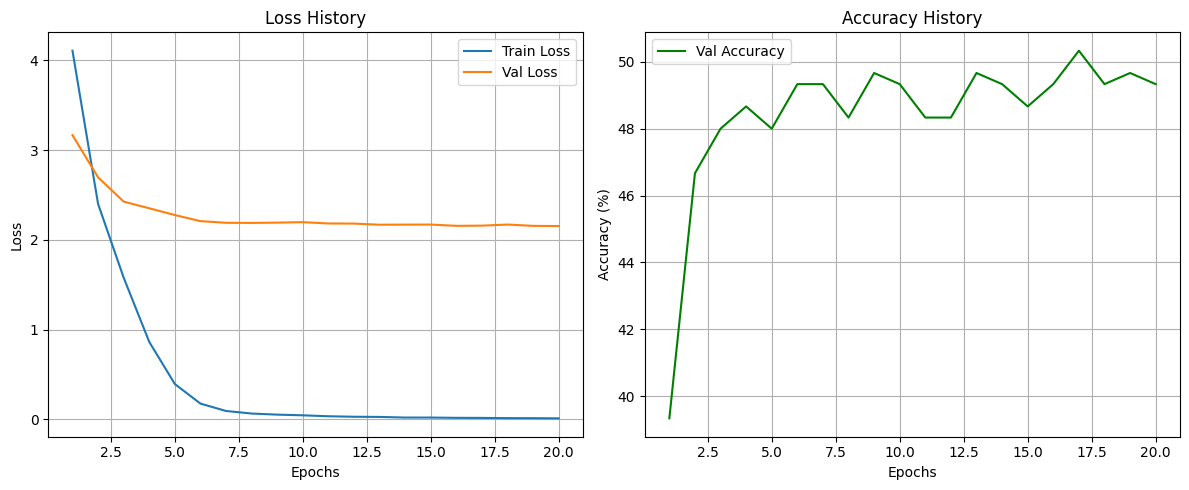

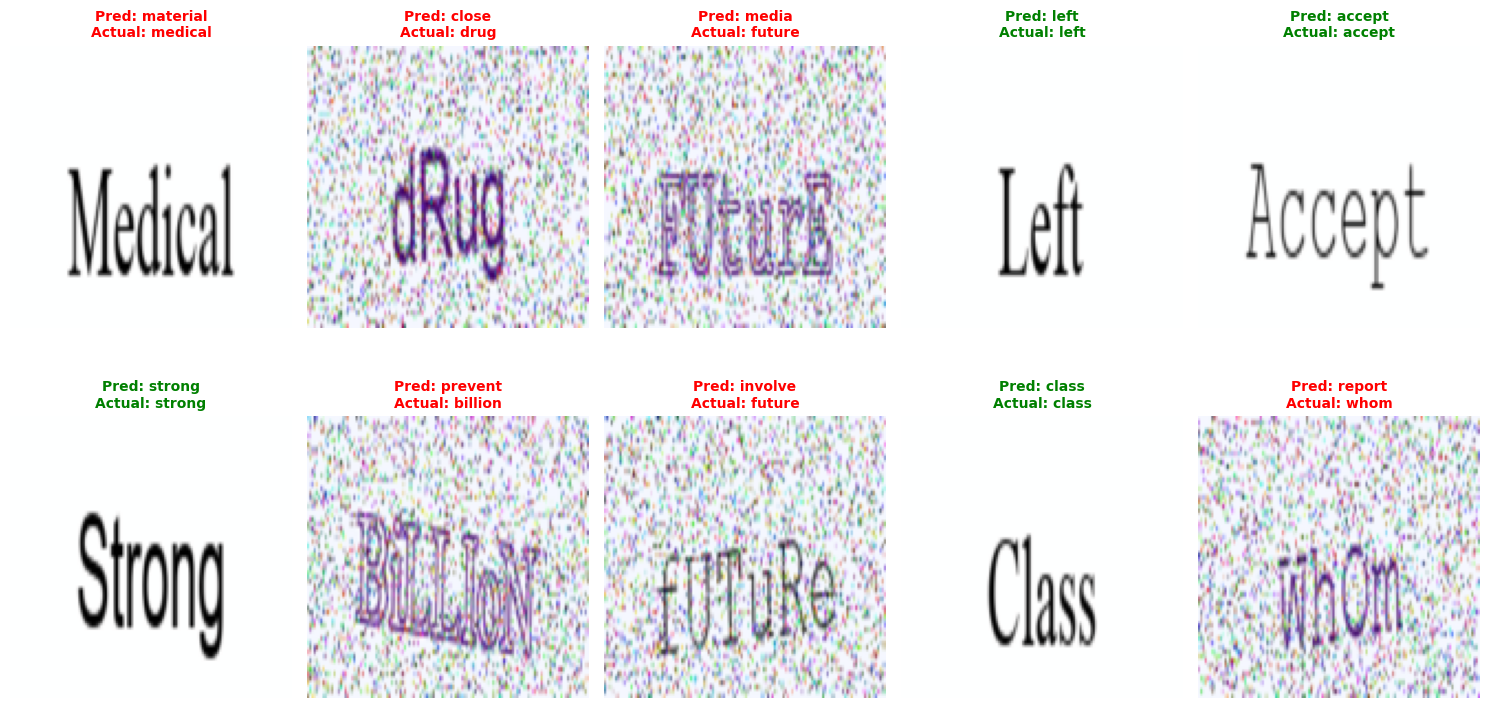

In [ ]:
model = models.resnet18(weights='DEFAULT')
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Linear(model.fc.in_features, 100) 
model = model.to(DEVICE)

train_model(model, "best_resnet_model.pth", 0.0005)

## CNN + ATTENTION (SE / CBAM)

#### This model introduces Channel Attention through the Squeeze-and-Excitation (SE) Block. While a standard CNN treats every feature map (channel) with equal importance, this model learns to "re-weight" them based on their usefulness. The code F.adaptive_avg_pool2d(x, 1) "squeezes" each $H \times W$ feature map into a single numerical value. This summarizes the global content of each channel. It allows the model to understand the context of the entire image rather than just looking at local pixels. The two linear layers (fc1 and fc2) act as a small "bottleneck" brain. They look at the squeezed values and decide which channels are important. So this model focuses on the linguistic structure of the letters and suppresses the channels that are picking up the synthetic interference you added.

Epoch [1/20] Train Loss: 4.6442 | Val Loss: 4.4004 | Val Acc: 4.33% <-- Best Model Saved!
Epoch [2/20] Train Loss: 3.9667 | Val Loss: 3.8407 | Val Acc: 19.67% <-- Best Model Saved!
Epoch [3/20] Train Loss: 3.1761 | Val Loss: 3.1856 | Val Acc: 29.33% <-- Best Model Saved!
Epoch [4/20] Train Loss: 2.4177 | Val Loss: 2.7289 | Val Acc: 42.00% <-- Best Model Saved!
Epoch [5/20] Train Loss: 1.7835 | Val Loss: 2.4188 | Val Acc: 45.00% <-- Best Model Saved!
Epoch [6/20] Train Loss: 1.2390 | Val Loss: 2.1141 | Val Acc: 51.33% <-- Best Model Saved!
Epoch [7/20] Train Loss: 0.7781 | Val Loss: 1.8895 | Val Acc: 56.67% <-- Best Model Saved!
Epoch [8/20] Train Loss: 0.4460 | Val Loss: 1.7434 | Val Acc: 60.33% <-- Best Model Saved!
Epoch [9/20] Train Loss: 0.2472 | Val Loss: 1.5650 | Val Acc: 62.67% <-- Best Model Saved!
Epoch [10/20] Train Loss: 0.1507 | Val Loss: 1.4863 | Val Acc: 64.67% <-- Best Model Saved!
Epoch [11/20] Train Loss: 0.1039 | Val Loss: 1.3967 | Val Acc: 65.00% <-- Best Model Saved

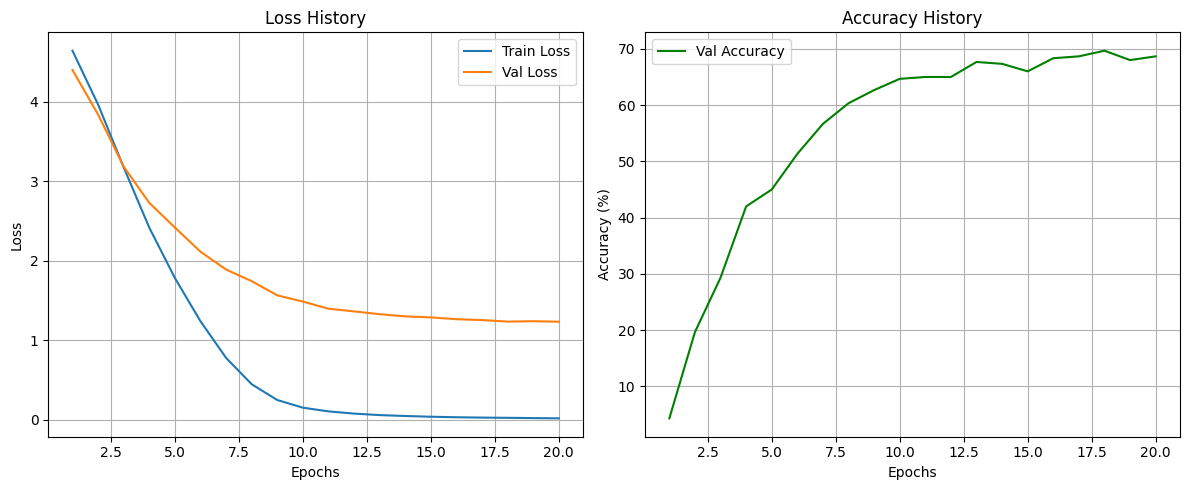

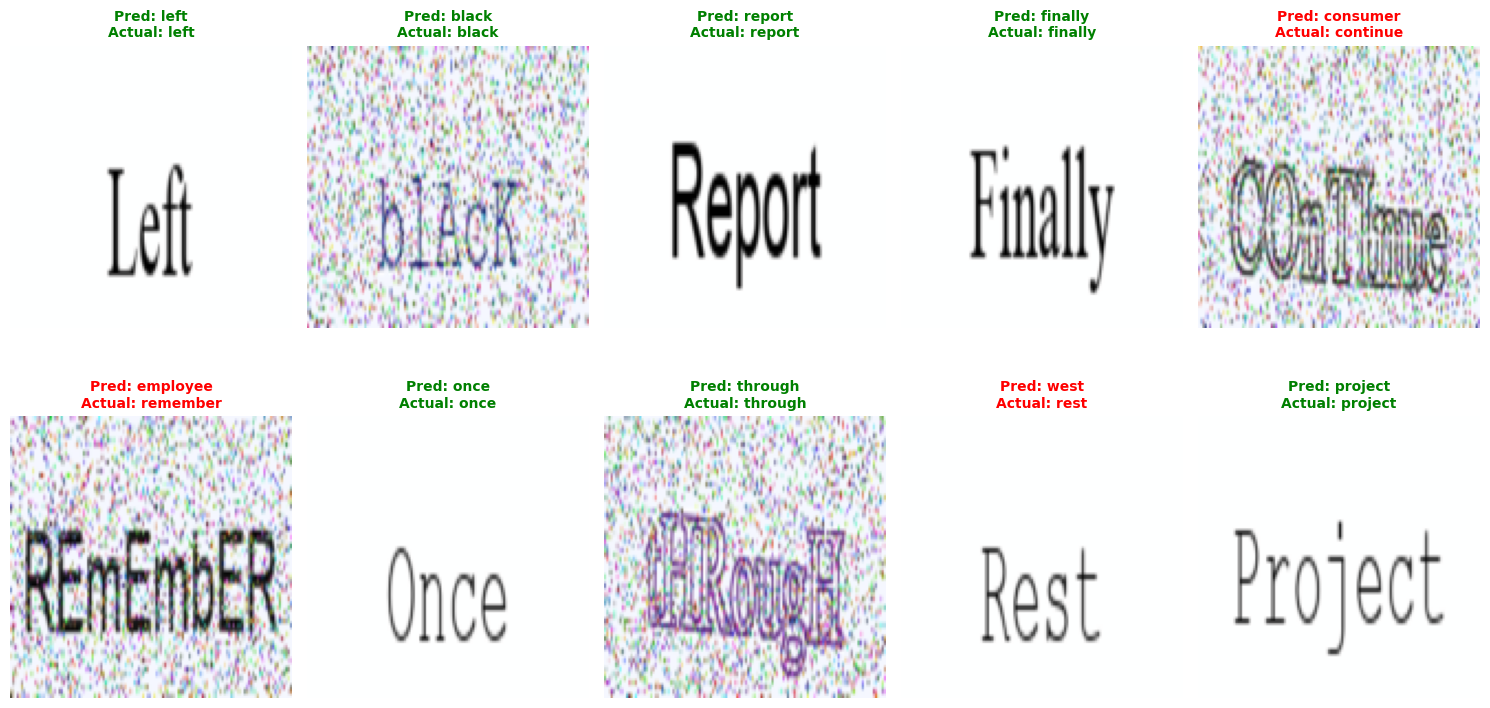

In [48]:
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, h, w = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

class CaptchaCNN_SE(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            SEBlock(32),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            SEBlock(64),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            SEBlock(128),
            nn.MaxPool2d(2)
        )

        self.fc1 = nn.Linear(32768, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)
    
model = CaptchaCNN_SE(num_classes=100).to(DEVICE)
train_model(model, "best_cnn_se.pth")

## CNN + Transformer

#### Here the model did not converge very well, maybe due to 
1. dataset size
2. Transformer models are data hungry and our dataset is not that big

Epoch [1/20] Train Loss: 4.7183 | Val Loss: 4.6795 | Val Acc: 0.33% <-- Best Model Saved!
Epoch [2/20] Train Loss: 4.6605 | Val Loss: 4.6657 | Val Acc: 0.67% <-- Best Model Saved!
Epoch [3/20] Train Loss: 4.6428 | Val Loss: 4.6671 | Val Acc: 1.00%
Epoch [4/20] Train Loss: 4.6413 | Val Loss: 4.6697 | Val Acc: 0.33%
Epoch [5/20] Train Loss: 4.6249 | Val Loss: 4.6553 | Val Acc: 1.00% <-- Best Model Saved!
Epoch [6/20] Train Loss: 4.6118 | Val Loss: 4.6340 | Val Acc: 1.00% <-- Best Model Saved!
Epoch [7/20] Train Loss: 4.5625 | Val Loss: 4.5696 | Val Acc: 1.67% <-- Best Model Saved!
Epoch [8/20] Train Loss: 4.4408 | Val Loss: 4.4658 | Val Acc: 2.33% <-- Best Model Saved!
Epoch [9/20] Train Loss: 4.2646 | Val Loss: 4.2014 | Val Acc: 1.67% <-- Best Model Saved!
Epoch [10/20] Train Loss: 4.0742 | Val Loss: 4.0725 | Val Acc: 2.33% <-- Best Model Saved!
Epoch [11/20] Train Loss: 3.9618 | Val Loss: 4.0322 | Val Acc: 3.67% <-- Best Model Saved!
Epoch [12/20] Train Loss: 3.8703 | Val Loss: 3.9441 

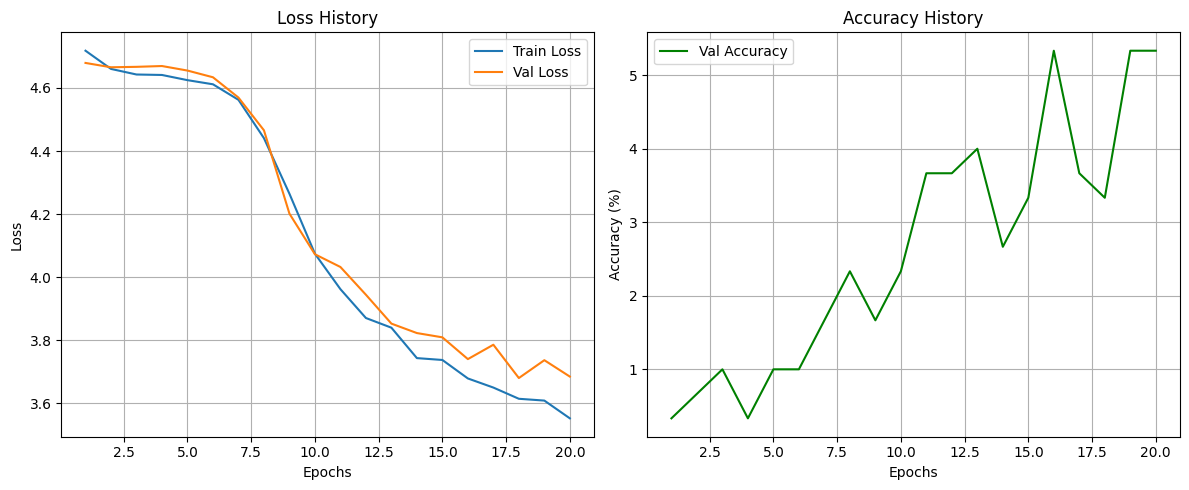

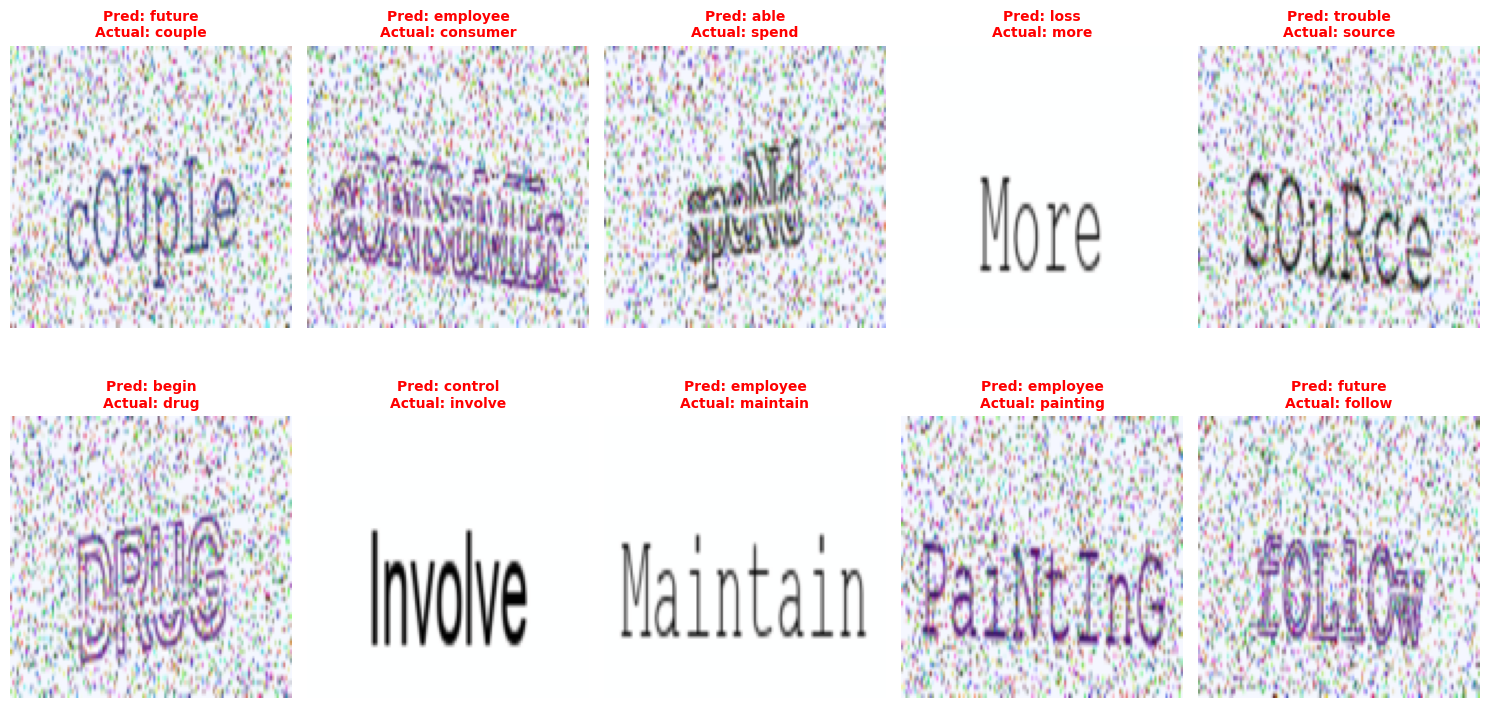

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNTransformer(nn.Module):
    def __init__(self, num_classes=100, embed_dim=256, num_heads=8, num_layers=4):
        super().__init__()

        # 1. Improved CNN Backbone: Extract deeper features
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # (B, 64, 32, 100)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2), # (B, 128, 16, 50)
            
            nn.Conv2d(128, embed_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU()        # (B, 256, 16, 50)
        )

        self.pos_encoder = nn.Parameter(torch.randn(1, 50, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            dim_feedforward=512,
            dropout=0.1,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        # x shape: (B, 3, 64, 200)
        x = self.cnn(x)              # (B, 256, 16, 50)
        
        x = F.adaptive_avg_pool2d(x, (1, 50)) # (B, 256, 1, 50)
        x = x.squeeze(2)                      # (B, 256, 50)
        x = x.permute(0, 2, 1)                # (B, 50, 256) -> (Batch, Seq_Len, Embed_Dim)

        x = x + self.pos_encoder

        x = self.transformer(x)               # (B, 50, 256)

        x = x.mean(dim=1)                     # (B, 256)
        return self.fc(x)


model = CNNTransformer(num_classes=100).to(DEVICE)
train_model(model, "best_cnn_transformer_model.pth", LR=0.0005, EPOCHS=20)